In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import (
    Dataset,
    KNNBaseline,
    KNNBasic,
    KNNWithMeans,
    KNNWithZScore,
    NMF,
    SVD,
    Reader,
)
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split
from tabulate import tabulate
import datetime
import time


In [2]:
flipkart = pd.read_csv("../newData/flipkart_cleaned.csv")
flipkart

,uniq_id,product_name,product_category_tree,pid,retail_price,discounted_price,discount,description,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,alisha solid women's cycling shorts,"['clothing', ""women's clothing"", 'lingerie, sl...",srteh2ff9kedefgf,999.0,379.0,62.06,key features of alisha solid women's cycling s...,no rating available,alisha,number of contents in sales package: pack of 3...
1,7f7036a6d550aaa89d34c77bd39a5e48,fabhomedecor fabric double sofa bed,"['furniture', 'living room furniture', 'sofa b...",sbeeh3qgu7mfyjfy,32157.0,22646.0,29.58,fabhomedecor fabric double sofa bed (finish co...,no rating available,fabhomedecor,installation & demo details: installation and ...
2,f449ec65dcbc041b6ae5e6a32717d01b,aw bellies,"['footwear', ""women's footwear"", 'ballerinas',...",shoeh4grsubjgzxe,999.0,499.0,50.05,key features of aw bellies sandals wedges heel...,no rating available,aw,ideal for: women occasion: casual color: red o...
3,0973b37acd0c664e3de26e97e5571454,alisha solid women's cycling shorts,"['clothing', ""women's clothing"", 'lingerie, sl...",srteh2f6huzmq6sj,699.0,267.0,61.80,key features of alisha solid women's cycling s...,no rating available,alisha,number of contents in sales package: pack of 2...
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,sicons all purpose arnica dog shampoo,"['pet supplies', 'grooming', 'skin & coat care...",psoeh3zydmsyarj5,220.0,210.0,4.55,specifications of sicons all purpose arnica do...,no rating available,sicons,pet type: dog brand: sicons quantity: 500 ml m...
...,...,...,...,...,...,...,...,...,...,...,...
19901,7179d2f6c4ad50a17d014ca1d2815156,walldesign small vinyl sticker,"['baby care', 'baby & kids gifts', 'stickers',...",stie7kfjakstdy9g,1500.0,730.0,51.33,buy walldesign small vinyl sticker for rs.730 ...,no rating available,walldesign,number of contents in sales package: pack of 5...
19902,71ac419198359d37b8fe5e3fffdfee09,wallmantra large vinyl stickers sticker,"['baby care', 'baby & kids gifts', 'stickers',...",stie9f5urnqgjcgh,1429.0,1143.0,20.01,buy wallmantra large vinyl stickers sticker fo...,no rating available,wallmantra,number of contents in sales package: pack of 1...
19903,93e9d343837400ce0d7980874ece471c,elite collection medium acrylic sticker,"['baby care', 'baby & kids gifts', 'stickers',...",stie7vaydkqzebsd,1299.0,999.0,23.09,buy elite collection medium acrylic sticker fo...,no rating available,elite collection,number of contents in sales package: pack of 1...
19904,669e79b8fa5d9ae020841c0c97d5e935,elite collection medium acrylic sticker,"['baby care', 'baby & kids gifts', 'stickers',...",stie8ysveppcz42y,1499.0,1199.0,20.01,buy elite collection medium acrylic sticker fo...,no rating available,elite collection,number of contents in sales package: pack of 1...


In [3]:
product_ids = flipkart['uniq_id'].tolist()
product_ids

['c2d766ca982eca8304150849735ffef9',
 '7f7036a6d550aaa89d34c77bd39a5e48',
 'f449ec65dcbc041b6ae5e6a32717d01b',
 '0973b37acd0c664e3de26e97e5571454',
 'bc940ea42ee6bef5ac7cea3fb5cfbee7',
 'c2a17313954882c1dba461863e98adf2',
 'ce5a6818f7707e2cb61fdcdbba61f5ad',
 '8542703ca9e6ebdf6d742638dfb1f2ca',
 '29c8d290caa451f97b1c32df64477a2c',
 '4044c0ac52c1ee4b28777417651faf42',
 'e54bc0a7c3429da2ebef0b30331fe3d2',
 'c73e78fb440ff8972e0762daed4fc109',
 '9aacdecceb404c74abddc513fd2756a8',
 '83c53f8948f508f51d2249b489ca8e7d',
 'd95b0456a0350bc42f2393c6e84b0f09',
 '849ab05698081a374215d0b7d18047d0',
 'c275ee5ac19f774a3ef7da71b40aabd8',
 '4f3511c33a6869b1d5102cd97818ef00',
 '7ee3e337474a29b38cfe1f5d4020d633',
 'f35f27525ab8f5988d3817ee9bb02ce1',
 '7a7ba93ab20a2b50fd5a7dc74bcba063',
 '9c26a5d85a59d6a34a199ae1df836ec3',
 '20cf08ae845d5fd8f2b8cf52b3b9d840',
 'bb41283056536d7af11e994ba4f9db81',
 'ea91e47cac68b132887d7fc1175e91c2',
 'bec784ef794cf596dbe2cbbaf5427ef0',
 '171e0bcea390c17fd70e3ffa6c2cd187',
 

In [4]:
orderdata = pd.read_csv("../newData/synthetic_v2.csv")
orderdata = orderdata.rename(columns={'Product ID': 'uniq_id'})
orderdata

,Order ID,uniq_id,Product Quantity,Product Price Each,Order Total,Order Date,Purchase Address,User rating for the product,User ID,User Age,User Occupation,User Income,User Interests,User Ethnicity
0,O0000001,bcdbd9eb52d0ef36ae58304361aa0f8a,1,299.0,897.0,2023-12-02,"824 Oak St., New York",0.5,U06610,60,Scientist,78126,Music,African American
1,O0000002,295a91fba41a32de41d5287e16557602,3,799.0,3644.0,2023-04-10,"414 Oak St., Chicago",0.1,U07439,36,Lawyer,65710,Travel,Asian
2,O0000002,0ee3888adfffc1099e998839ea7bc1d1,2,499.0,3644.0,2023-04-10,"414 Oak St., Chicago",0.6,U07439,36,Lawyer,65710,Travel,Asian
3,O0000002,0da164821ae77ebad5bc7962a42b59ac,1,299.0,3644.0,2023-04-10,"414 Oak St., Chicago",2.5,U07439,36,Lawyer,65710,Travel,Asian
4,O0000002,2ab4e6b6e8c228399ee081aa696cf218,2,250.0,3644.0,2023-04-10,"414 Oak St., Chicago",3.3,U07439,36,Lawyer,65710,Travel,Asian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124963,O0049998,4a34d64b7cf1add16c9d7974bb3fb9a7,3,293.0,6608.0,2023-08-15,"402 Elm St., Houston",1.9,U08305,53,Accountant,113289,Sports; Electronics,Hispanic
124964,O0049999,81f305096865f5092608efd7e8005d4a,2,1399.0,1399.0,2023-05-25,"415 Elm St., New York",3.6,U01811,35,Lawyer,33013,Travel; Fitness,Asian
124965,O0050000,67788411870839f0117fd0e89fa1f2ce,3,599.0,2546.0,2023-07-01,"488 Oak St., Los Angeles",5.0,U02925,25,Teacher,135629,Travel; Fashion; Books,African American
124966,O0050000,3d6c1d9ba9a5d7f8dbf06c43f1068f77,2,699.0,2546.0,2023-07-01,"488 Oak St., Los Angeles",0.9,U02925,25,Teacher,135629,Travel; Fashion; Books,African American


### Memory Based Recommendations

In [5]:
np.random.seed(0)
random.seed(0)

In [6]:
reader = Reader(rating_scale=(0, 5))
dataset = Dataset.load_from_df(orderdata[['User ID' ,'uniq_id', 'User rating for the product']], reader)

In [7]:
memory_algos = (
    KNNBasic(verbose=False),
    KNNWithMeans(verbose=False),
    KNNBaseline(verbose=False),
    KNNWithZScore(verbose=False),
)

In [8]:
kf =  KFold(random_state=0)
table = []

#summary of all the memory based algorithms based on k-nearest neighbours
for algo in memory_algos:
    start = time.time()
    out = cross_validate(algo, dataset, ["rmse", "mae"], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    algo_name = algo.__class__.__name__
    mean_rmse = "{:.3f}".format(np.mean(out["test_rmse"]))
    mean_mae = "{:.3f}".format(np.mean(out["test_mae"]))

    new_line = [algo_name, mean_rmse, mean_mae, cv_time]
    table.append(new_line)

header = ["Memory-Based Algorithm", "RMSE", "MAE", "Time"]
print(tabulate(table, header, tablefmt="pipe"))

| Memory-Based Algorithm   |   RMSE |   MAE | Time    |
|:-------------------------|-------:|------:|:--------|
| KNNBasic                 |  1.442 | 1.235 | 0:00:06 |
| KNNWithMeans             |  1.516 | 1.281 | 0:00:11 |
| KNNBaseline              |  1.45  | 1.233 | 0:00:11 |
| KNNWithZScore            |  1.515 | 1.28  | 0:00:08 |


In [9]:
trainset, testset = train_test_split(dataset, test_size=0.3, random_state=42)

sim_options = {
    'name': 'pearson',
    'user_based': False,
    'min_support': 5
}

memory_model = KNNBaseline(k=50, min_k=5, sim_options=sim_options)
memory_model.fit(trainset)
memory_predictions = memory_model.test(testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [10]:
df_pred = pd.DataFrame(memory_predictions, columns=['userId', 'uniqID', 'actual_rating', 'pred_rating', 'details'])

df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)
df_pred

,userId,uniqID,actual_rating,pred_rating,impossible,abs_err
0,U06131,0a22d5cf4965d258b58036c58be34a27,4.2,2.892087,False,1.307913
1,U06158,f457fbaccb1faa563485e52e7a761330,3.7,2.447130,False,1.252870
2,U07743,98d92b1bc2bfaee40ba460634d981df1,3.5,2.650103,False,0.849897
3,U05361,21fe4973294d9cbbfd606a7aa5d6de9a,4.4,2.390342,False,2.009658
4,U05224,fe63a55f392fd5924391f831afc1ddc7,4.4,2.579265,False,1.820735
...,...,...,...,...,...,...
37486,U03877,93ab4df7174a05c9fddedf4e76142306,1.0,3.034552,False,2.034552
37487,U07228,4a037568bf8bc65b7ca3a28284a42111,3.4,2.765065,False,0.634935
37488,U04575,8f0fbc493bce73f3474dd8954c1511a5,4.1,3.093571,False,1.006429
37489,U06639,20c5be2abcd74be04a2584c895cec340,0.4,3.116544,False,2.716544


/var/folders/rd/t3xtrw6x6cn_9qvx9ywrkj4c0000gn/T/ipykernel_42405/3143295468.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='User rating for the product', data=orderdata, palette=palette)
/var/folders/rd/t3xtrw6x6cn_9qvx9ywrkj4c0000gn/T/ipykernel_42405/3143295468.py:4: UserWarning: 
The palette list has fewer values (10) than needed (51) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='User rating for the product', data=orderdata, palette=palette)


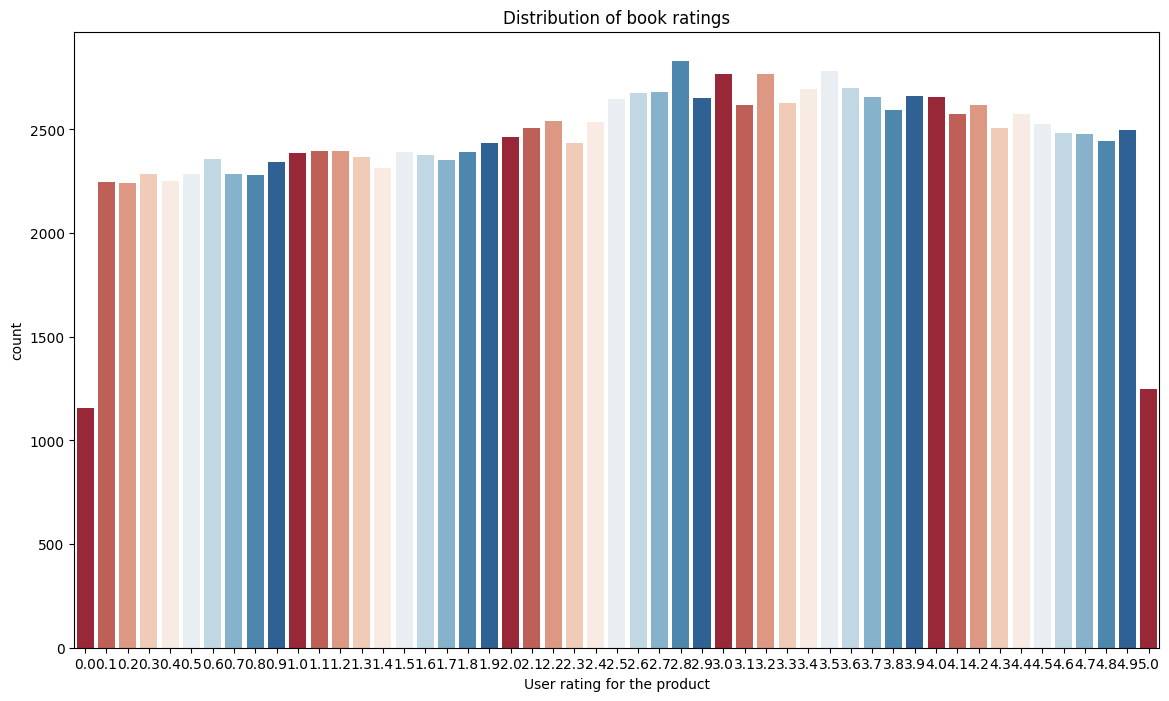

In [11]:
palette = sns.color_palette("RdBu", 10)

fig, ax = plt.subplots(figsize=(14, 8))
sns.countplot(x='User rating for the product', data=orderdata, palette=palette)
ax.set_title('Distribution of product ratings')

plt.show()

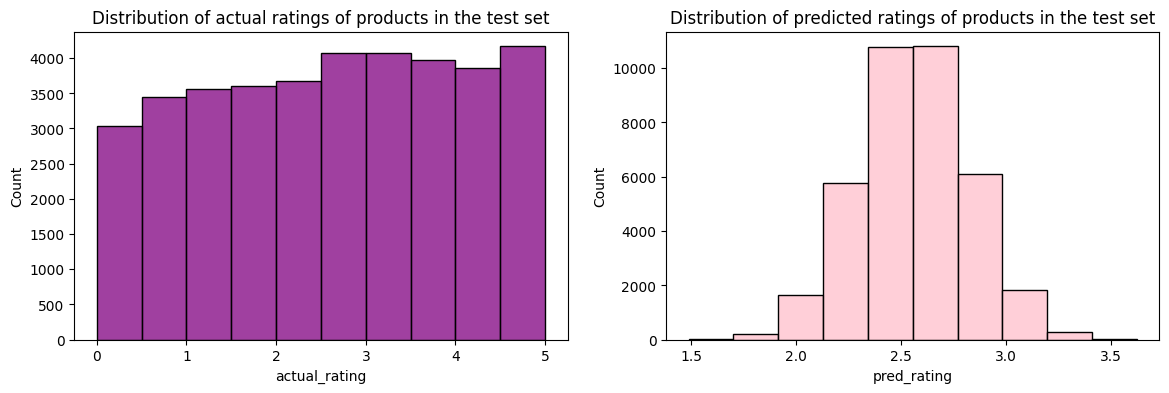

In [12]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.histplot(x='actual_rating', data=df_pred, color="purple", ax=ax1, bins=10)
ax1.set_title('Distribution of actual ratings of products in the test set')

sns.histplot(x='pred_rating', data=df_pred,color="pink", ax=ax2, bins=10)
ax2.set_title('Distribution of predicted ratings of products in the test set')

plt.show()

/var/folders/rd/t3xtrw6x6cn_9qvx9ywrkj4c0000gn/T/ipykernel_42405/1325967356.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
/var/folders/rd/t3xtrw6x6cn_9qvx9ywrkj4c0000gn/T/ipykernel_42405/1325967356.py:10: UserWarning: 
The palette list has fewer values (10) than needed (51) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)


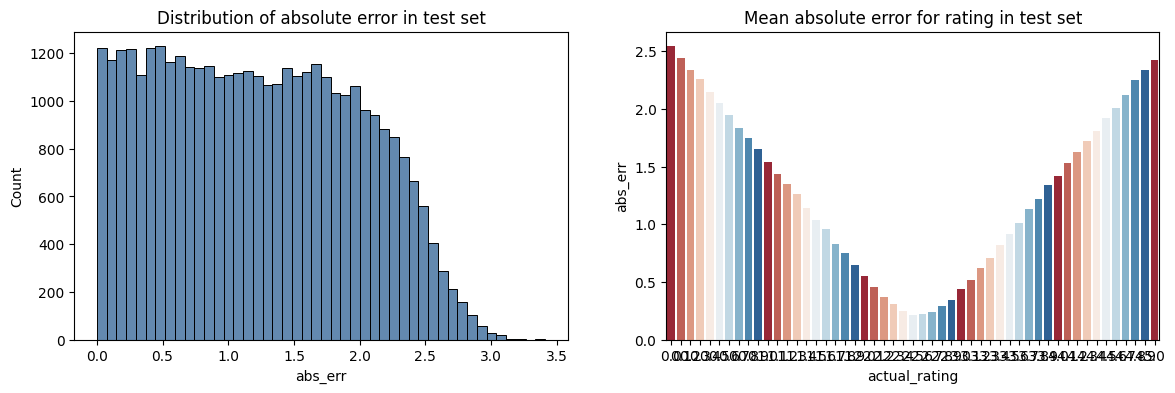

In [13]:
# absolute error

df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

sns.histplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

### Non-Negative Matrix Factorisation

In [14]:
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, dataset, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse    1.731814
test_mae     1.420828
fit_time     4.575621
test_time    0.204650
dtype: float64

### Singular Value Decomposition

In [15]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, dataset, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse    1.447008
test_mae     1.232877
fit_time     1.205666
test_time    0.276993
dtype: float64

#### With grid-search to optimize further

In [16]:
param_grid = {'n_factors': [80,100,120],
              'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(dataset)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])